# Resnet

### Imports

In [50]:
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os


###  Preprocessing

The images have previously been loaded into BENIGN and MALIGNANT folders. 
First we must resize them to 256x256 and then convert them to numpy arrays.
We will now load them into a dataframe and split them into training and validation sets.

In [48]:
# using splitfolder to split training data into train and validation
import splitfolders

# split data into train and validation
splitfolders.ratio('data/train', output="data_split", seed=1337, ratio=(.8, .2))

Copying files: 1318 files [00:17, 74.28 files/s]


In [61]:
IMG_SIZE = 256

In [62]:
# Loads training data
train_datagen = ImageDataGenerator(
    rescale=1/255,  # rescale the tensor values to [0,1]
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    directory='data_split/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True,
)

Found 1053 images belonging to 2 classes.


In [63]:
train_generator.class_indices

{'BENIGN': 0, 'MALIGNANT': 1}

In [16]:
cv.imread('data/train/MALIGNANT/2.jpg').shape


(256, 256, 3)

In [64]:
val_test_datagen = ImageDataGenerator(
    rescale=1/255  # rescale the tensor values to [0,1]
)
val_generator = val_test_datagen.flow_from_directory(
    directory='data_split/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    class_mode="binary",
    batch_size=32,
    shuffle=True
)

Found 265 images belonging to 2 classes.


#### Implemenmtation of Resnet

In [55]:
model_file = 'data/resnet_model.h5'
data_dir = 'data'

In [65]:
pretrained_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling='max',
    classes=2,
)

model_layers = [
    pretrained_model,
    layers.Dense(units=512, activation='relu', kernel_regularizer=L2(
        0.0001), bias_regularizer=L2(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(units=128, activation='relu', kernel_regularizer=L2(
        0.0001), bias_regularizer=L2(0.0001)),
    layers.Dense(units=1, activation='sigmoid'),
]



In [66]:
model = Sequential(layers=model_layers)

In [67]:
custom_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=5,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=model_file,
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True
    ),
]

In [68]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
history = model.fit(
    train_generator,
    epochs=5,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=custom_callbacks,
    verbose=2
    # use_multiprocessing=True,
)


Epoch 1/5
33/33 [==============================] - ETA: 0s - loss: 2.2848 - accuracy: 0.5413 
Epoch 00001: val_loss improved from inf to 1.66169, saving model to data\resnet_model.h5


C:\Users\Vegard\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


33/33 [==============================] - 734s 22s/step - loss: 2.2848 - accuracy: 0.5413 - val_loss: 1.6617 - val_accuracy: 0.5170
Epoch 2/5
33/33 [==============================] - ETA: 0s - loss: 1.4272 - accuracy: 0.5603 
Epoch 00002: val_loss improved from 1.66169 to 1.14036, saving model to data\resnet_model.h5
33/33 [==============================] - 681s 21s/step - loss: 1.4272 - accuracy: 0.5603 - val_loss: 1.1404 - val_accuracy: 0.4830
Epoch 3/5
33/33 [==============================] - ETA: 0s - loss: 1.1479 - accuracy: 0.5878 
Epoch 00003: val_loss improved from 1.14036 to 0.79774, saving model to data\resnet_model.h5
33/33 [==============================] - 635s 19s/step - loss: 1.1479 - accuracy: 0.5878 - val_loss: 0.7977 - val_accuracy: 0.5057
Epoch 4/5
33/33 [==============================] - ETA: 0s - loss: 1.0714 - accuracy: 0.5670 
Epoch 00004: val_loss did not improve from 0.79774
33/33 [==============================] - 598s 18s/step - loss: 1.0714 - accuracy: 0.5670

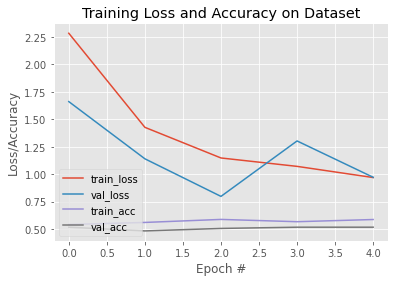

In [70]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = 5
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('data/plot.png')


In [ ]:
# create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(val_generator.classes, model.predict(val_generator).round())
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('data/confusion_matrix.png')
